### 一. Original Hard-marginal SVM

+ 动机：找一条胖胖的分割线，使得算法的VC维低，即所得模型的通用性高，不容易过拟合（相对于PLA）

+ 抽象为最优化问题，并将公式一步步转化为容易解决的二次规划问题

$$\max\limits_{w,b} fatness(w, b)$$
$$s.t.$$
$$y_n (w^T x_n + b) \geq 0$$
$$fatness(w, b) = \min\limits_{0 \leq n < N} distance(x_n, w, b) $$

$$\Downarrow margin \leftarrow fatness, 展开distance, 且意识到y_n (w^T x_n + b) =|w^T x_n + b|$$

$$\max \limits_{w,b} margin(w, b)$$
$$s.t.$$
$$margin(w, b) = \min\limits_{0 \leq n < N} \frac{1}{||w||} y_n (w^T x_n + b) $$

$$\Downarrow 利用平面的放缩不变性，使得margin(w,b) = \frac{1}{||w||} $$

$$\max \limits_{w,b} \frac{1}{||w||} $$
$$s.t.$$
$$\min\limits_{0 \leq n < N}  y_n (w^T x_n + b) = 1$$

$$\Downarrow 放松限制条件，将最大化变最小化，点积代替取模运算 $$

$$\min \limits_{w,b} \frac{1}{2} w^T w $$
$$s.t.$$
$$y_n (w^T x_n + b) \geq 1$$

    上述放松限制条件的操作之所以有效，可以用反证法证明在放松的限制条件下得到的w和b和原问题一致．上述问题可以直接丢到现成的二次规划算法里面求解．上述分类平面是线性的，若要实现非线性的效果，可以对原始特征进行转化（到高维空间）．下面就用解二次规划的方法来实现SVM，其中所用Solver来自CVXOPT包：

$$ \min \frac{1}{2}u^T Q u + p^T u $$
$$ s.t. $$
$$ G u \leq h $$
$$ A u = b $$

$$ u = \left[ \begin{array}{c} b \\ w \\ \end{array} \right], Q = \left[ \begin{array}{cc} 0 & 0_{1*d} \\ 0_{d*1} & I_{d*d} \end{array} \right], p = 0_{(d+1)*1}, G_{n*(d+1)} = \left[ \begin{array}{c} . \\ . \\ -y_n [1, x_n^T] \\ \end{array} \right], h = -1_{n}$$

$$ cvxopt.solvers.qp(Q, p, [, G, h [, A, b]]) $$

In [32]:
# 导入iris数据集
from sklearn import datasets
import numpy as np
from cvxopt import matrix, solvers

iris = datasets.load_iris()
iris = zip(iris.data, iris.target)
iris_01 = filter(lambda (X, y): y == 0 or y == 1, iris)
X = np.array(map(lambda (X, y): X, iris_01))[:, 0:2]
Y = np.array(map(lambda (X, y): 1 if y == 0 else -1, iris_01))
Y.shape = (len(X), 1)

In [39]:
%%time

#调用QP程序得到分类面(w, b)
d = X.shape[1]
n = X.shape[0]
Q = np.eye(d + 1)
Q[0][0] = 0
p = np.zeros((d + 1, 1))
G = np.hstack((np.ones((n, 1)), X)) * -Y
h = - np.ones((n, 1))

Q = matrix(Q)
p = matrix(p)
G = matrix(G)
h = matrix(h)

sol = solvers.qp(Q, p, G, h)

b = sol['x'][0]
w = sol['x'][1:]
print '-' * 100
print 'b:'
print b
print 'w:'
print w

     pcost       dcost       gap    pres   dres
 0:  1.1014e+00  5.0091e+01  3e+02  2e+00  1e+02
 1:  7.5918e+00 -4.5992e+01  1e+02  8e-01  4e+01
 2:  1.6944e+01 -4.1454e+01  1e+02  5e-01  2e+01
 3:  3.1275e+01 -2.6478e+00  5e+01  2e-01  7e+00
 4:  3.3601e+01  3.0481e+01  4e+00  1e-02  5e-01
 5:  3.3793e+01  3.3757e+01  4e-02  1e-04  6e-03
 6:  3.3795e+01  3.3795e+01  4e-04  1e-06  6e-05
 7:  3.3795e+01  3.3795e+01  4e-06  1e-08  6e-07
 8:  3.3795e+01  3.3795e+01  4e-08  1e-10  6e-09
Optimal solution found.
----------------------------------------------------------------------------------------------------
b:
17.3157894733
w:
[-6.32e+00]
[ 5.26e+00]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.88 ms


In [40]:
def predict(x):
    y = np.array(w).T.dot(x) + b
    return 0 if y < 0 else 1

print predict((7.98, 5.0))
print predict((3.02, 1.0))

0
1


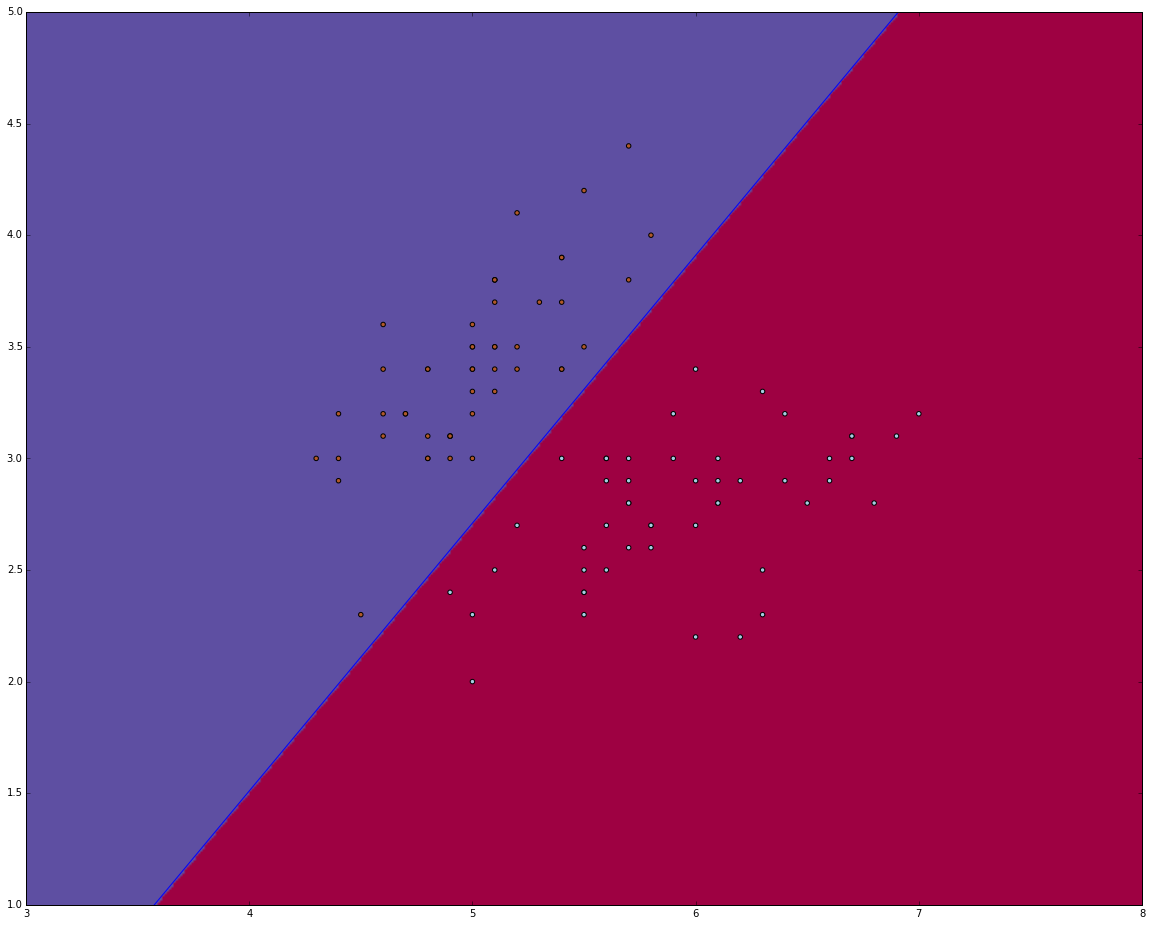

In [41]:
%matplotlib inline

def draw_clf_plane(X, predict, w, b):
    import numpy as np
    import matplotlib.pyplot as plt
    import functools as ft
    
    f = plt.figure('Original Hard-Margin SVM', figsize=(20, 20))
    
    x0_min, x0_max = int(min(X[:, 0]) - 1), int(max(X[:, 0]) + 1)
    x1_min, x1_max = int(min(X[:, 1]) - 1), int(max(X[:, 1]) + 1)

    plt.xlim(x0_min, x0_max)
    plt.ylim(x1_min, x1_max)

    # draw classification background
    density = 100
    N1 = (x1_max - x1_min) * density
    N0 = (x0_max - x0_min) * density
    class_map = [[(float(i) / density + x1_min, float(j) / density + x0_min) for j in xrange(N0)] for i in xrange(N1, 0, -1)]
    class_map = map(ft.partial(map, lambda x: predict((x[1], x[0]))), class_map)
    plt.imshow(class_map, cmap=plt.cm.Spectral, extent=[x0_min, x0_max, x1_min, x1_max])

    # drew data
    plt.scatter(X[:, 0], X[:, 1] , c=Y, cmap=plt.cm.Paired)

    #draw classification hyberplane
    line_x = np.linspace(x0_min, x0_max)
    line_y = map(lambda x0: (-b - w[0] * x0) / w[1], line_x)
    plt.plot(line_x, line_y)

    plt.show()

draw_clf_plane(X, predict, w, b)

## 二. Dual Hard-marginal SVM

+ 动机：原始二次规划问题的复杂度跟特征的维度有关系，即效率受限于特征的维度．想办法去除这一限制，以便可以对特征进行任意扩充，甚至可以扩充到无限维．

    要做到这一点，就要把原问题转化为其对偶问题。对偶有相反的意思，特定于目前的优化问题，就是优化变量的维度从样本的特征维度转到样本的个数。

    要做到这点，首先把之前的二次规划问题通过拉格朗日算子转化为最小最大化问题。

$$\min \limits_{w,b} \frac{1}{2} w^T w $$
$$s.t.$$
$$y_n (w^T x_n + b) \geq 1$$

$$\Downarrow 通过拉格朗日算子转化为最小最大化问题$$

$$ \min \limits_{w,b} \max \limits_{\alpha_n \geq 0} \{ \frac{1}{2} w^T w + \sum \limits_{n} \alpha_n (1 - y_n (w^T x_n + b)) \} $$

$$\Downarrow 通过 \min \max \geq \max \min 公式及强对偶条件，转化为等效的 \max \min 问题 $$

$$ \max \limits_{\alpha_n \geq 0} \min \limits_{w,b} \frac{1}{2} w^T w + \sum \limits_{n} \alpha_n (1 - y_n (w^T x_n + b)) $$

$$\Downarrow 先将 \min 问题通过求偏导进行转化 $$

$$ \sum \limits_{n} \alpha_n y_n = 0$$
$$ w = \sum \limits_{n} \alpha_n y_n x_n $$

$$ \max \limits_{\alpha_n \geq 0, \sum \limits_{n} \alpha_n y_n = 0, w = \sum \limits_{n} \alpha_n y_n x_n} - \frac{1}{2} \sum \limits_n \sum \limits_m \alpha_n \alpha_m y_n y_m x_n^T x_m + \sum \limits_{n} \alpha_n $$

$$\Downarrow 问题取反，转化为二次规划问题 $$

$$ \min \frac{1}{2} \alpha^T Q \alpha + p^T \alpha $$
$$ G \alpha \leq h $$
$$ A \alpha = b $$
$$ s.t. $$
$$ Q_{N*N} = \left[ \begin{array}{cc} . & . \\ . & y_n y_m x_n^T x_m \\ \end{array} \right] $$
$$ p_{n*1} = -1 $$
$$ G_{n*n} = -I $$ 
$$ h_{n*1} = 0 $$
$$ A_{n*1} = Y^T $$
$$ b_{1*1} = 0 $$

In [47]:
%%time

#调用QP程序得到分类面(w, b)
d = X.shape[1]
n = X.shape[0]

Q = [[Y[i, 0] * Y[j, 0] * np.dot(X[i], X[j]) for j in xrange(n)] for i in xrange(n)]
p = - np.ones((n, 1))
G = - np.eye(n)
h = np.zeros((n, 1))
A = np.array(Y.T, dtype='d')
b = np.zeros((1, 1))

print G

Q = matrix(Q)
p = matrix(p)
G = matrix(G)
h = matrix(h)
A = matrix(A)
b = matrix(b)


sol = solvers.qp(Q, p, G, h, A, b)

alpha = np.array(sol['x']).reshape((n, 1))

sv_idx = alpha.argmax()

w = np.sum(alpha * Y * X, axis=0)
b = Y[sv_idx,0] - np.dot(w, X[sv_idx])
print '-' * 100
print 'b:'
print b
print 'w:'
print w
print 'alpha:'
print alpha

    

[[-1. -0. -0. ..., -0. -0. -0.]
 [-0. -1. -0. ..., -0. -0. -0.]
 [-0. -0. -1. ..., -0. -0. -0.]
 ..., 
 [-0. -0. -0. ..., -1. -0. -0.]
 [-0. -0. -0. ..., -0. -1. -0.]
 [-0. -0. -0. ..., -0. -0. -1.]]
     pcost       dcost       gap    pres   dres
 0: -1.7775e+01 -3.8527e+01  3e+02  2e+01  2e+00
 1: -3.0310e+01 -3.6184e+01  1e+02  7e+00  8e-01
 2: -5.7279e+01 -5.4062e+01  1e+02  4e+00  5e-01
 3: -4.3187e+01 -4.2685e+01  5e+01  1e+00  2e-01
 4: -3.3936e+01 -3.4346e+01  4e+00  1e-01  1e-02
 5: -3.3794e+01 -3.3801e+01  4e-02  1e-03  1e-04
 6: -3.3795e+01 -3.3795e+01  4e-04  1e-05  1e-06
 7: -3.3795e+01 -3.3795e+01  4e-06  1e-07  1e-08
 8: -3.3795e+01 -3.3795e+01  4e-08  1e-09  1e-10
Optimal solution found.
84
----------------------------------------------------------------------------------------------------
b:
17.3157894733
w:
[-6.31578947  5.26315789]
alpha:
[[  2.36103253e-11]
 [  1.17233087e-10]
 [  6.53029244e-12]
 [  5.58110535e-12]
 [ -5.37382215e-13]
 [  1.00292559e-11]
 [ -1.5578

In [48]:

print predict((5, 1.5))
print predict((4, 2))

0
1


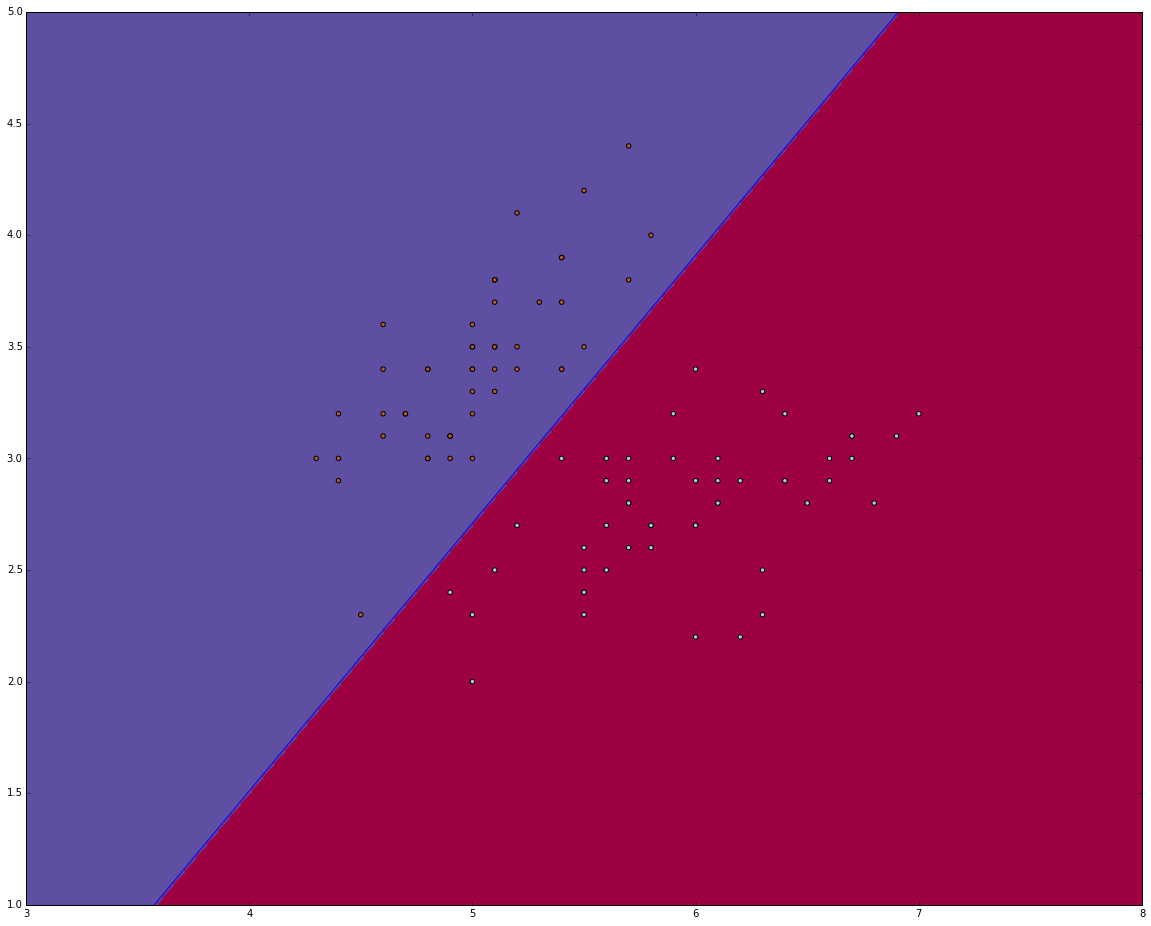

In [49]:
draw_clf_plane(X, predict, w, b)